In [1]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for att in range(10, 250, 20):
        # Load and compute data
        postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{att}.csv", delimiter=',', dtype=np.int8)
        dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd_dac = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
        energy_tot = power_tot * dt
        bw = 2**16 * 48 * bpc / dt # bits per second
        energy_per_bit = energy_tot / 2**16 / 48 / bpc
        edp = energy_per_bit / bw

        # Load data into confmat
        confmat = np.zeros(shape=(2**bpc, 2**bpc))
        for i in range(65536):
            for j in range(48):
                if j in [19,29,38,43]:
                    continue
                confmat[j % (2**bpc)][postread[i][j]] += 1
        confmat = confmat.astype(int)
        print(confmat)

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[1507278      50]
 [     67 1376189]]
[[1507303      25]
 [      0 1376256]]
[[1507296      32]
 [      0 1376256]]
[[1507297      31]
 [      0 1376256]]
[[1507301      27]
 [      0 1376256]]
[[1507300      28]
 [      0 1376256]]
[[1507301      27]
 [      0 1376256]]
[[1507299      29]
 [      0 1376256]]
[[1507298      30]
 [      0 1376256]]
[[1507292      36]
 [      0 1376256]]
[[1507292      36]
 [      0 1376256]]
[[1507297      31]
 [      0 1376256]]
[[786371     40      0     21]
 [  6599 681641  32447    209]
 [    14  25792 684302  10788]
 [     0      0   5383 649977]]
[[786383     19      0     30]
 [  5532 703028  12279     57]
 [    23  26634 693086   1153]
 [     0      0   6313 649047]]
[[786261     11      3    157]
 [  5962 708424   6453     57]
 [    13  27877 692532    474]
 [     0      1   6033 649326]]
[[786165      9      1    257]
 [  5975 709787   5059     75]
 [     3  28821 691758    314]
 [     0      1   6055 649304]]
[[786103      7      0    322]
 

,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,10,1,0.07848501205444336,0.196221,4.895646e-09,1.221450e-16,4.008062e+07,0.000041,0.000041,0.000041,0.006370
1,30,1,0.0791025161743164,0.139952,3.519227e-09,8.849452e-17,3.976774e+07,0.000009,0.000009,0.000009,0.002944
2,50,1,0.07672476768493652,0.144094,3.514467e-09,8.571836e-17,4.100016e+07,0.000011,0.000011,0.000011,0.003331
3,70,1,0.07497882843017578,0.149738,3.569021e-09,8.506807e-17,4.195488e+07,0.000011,0.000011,0.000011,0.003279
4,90,1,0.07296991348266602,0.152313,3.533133e-09,8.195635e-17,4.310993e+07,0.000009,0.000009,0.000009,0.003060
5,110,1,0.07340240478515625,0.159088,3.712165e-09,8.661965e-17,4.285593e+07,0.000010,0.000010,0.000010,0.003116
6,130,1,0.06999492645263672,0.161002,3.582416e-09,7.971158e-17,4.494223e+07,0.000009,0.000009,0.000009,0.003060
7,150,1,0.06965517997741699,0.164586,3.644390e-09,8.069695e-17,4.516144e+07,0.000010,0.000010,0.000010,0.003171
8,170,1,0.06833767890930176,0.160368,3.483820e-09,7.568237e-17,4.603212e+07,0.000010,0.000010,0.000010,0.003225
9,190,1,0.06933093070983887,0.162375,3.578700e-09,7.887352e-17,4.537265e+07,0.000012,0.000012,0.000012,0.003533


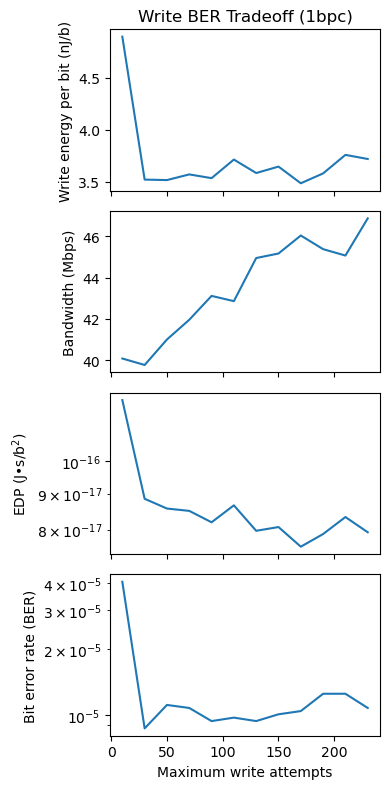

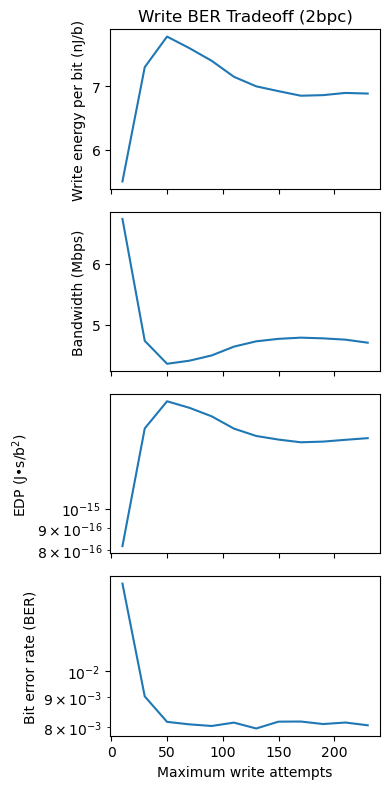

In [3]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()

## Experiments part

In [4]:
# Analyze reliability, bandwidth, energy
edata = []
datadir = "data/"
for fname in glob.glob(f"{datadir}/dt_*config*.csv"):
    # Extract info from filename
    _, _, bpc, lvl, expt, att = fname[:-4].split('_')[-6:]
    bpc, lvl, expt, att = int(bpc[0]), int(lvl[3:]), int(expt), int(att)

    # Load and compute data
    try:
        postread = np.loadtxt(fname.replace("dt", "postread"), delimiter=',', dtype=np.int8)
        dt = np.loadtxt(fname, delimiter=',')
        ivdd = np.loadtxt(fname.replace("dt", "vdd_power"), delimiter=',')
        ivdd_dac = np.loadtxt(fname.replace("dt", "vdd_dac_power"), delimiter=',')
        ivsa = np.loadtxt(fname.replace("dt", "vsa_power"), delimiter=',')
        ivddio = np.loadtxt(fname.replace("dt", "vddio_power"), delimiter=',')
        ivddio_dac = np.loadtxt(fname.replace("dt", "vddio_dac_power"), delimiter=',')
    except OSError:
        continue
    postread_cer = (postread != lvl).mean()
    power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
    energy_tot = power_tot * dt
    bw = 2**16 * 48 * bpc / dt # bits per second
    energy_per_bit = energy_tot / 2**16 / 48 / bpc
    edp = energy_per_bit / bw

    # Confusion vector
    confvec = np.unique(postread, return_counts=True)
    print(confvec)

    # Compose dataframe
    edata.append({"att": att, "bpc": bpc, "lvl": lvl, "expt": expt, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": postread_cer})
edata = pd.DataFrame(edata)
edata

(array([0, 1, 2, 3], dtype=int8), array([ 34929, 144972,   3794,  12913]))
(array([0, 1, 2, 3], dtype=int8), array([ 21525, 171047,   2683,   1353]))
(array([0, 1, 2, 3], dtype=int8), array([ 32091,    219, 118846,  45452]))
(array([0, 1, 2, 3], dtype=int8), array([ 44210,    322, 106896,  45180]))
(array([0, 1, 2, 3], dtype=int8), array([ 40008,    458, 103632,  52510]))
(array([0, 1, 2, 3], dtype=int8), array([ 29052,    574, 142772,  24210]))
(array([0, 1, 2, 3], dtype=int8), array([ 41805, 117420,  18488,  18895]))
(array([0, 1, 2, 3], dtype=int8), array([ 42826, 128106,  15036,  10640]))
(array([0, 1, 2, 3], dtype=int8), array([ 30687,    403, 133517,  32001]))
(array([0, 1, 2, 3], dtype=int8), array([ 34090,    522, 135794,  26202]))
(array([0, 1, 2, 3], dtype=int8), array([ 32202,   2017, 132123,  30266]))
(array([0, 1, 2, 3], dtype=int8), array([ 26024,    451, 141231,  28902]))
(array([0, 1, 2, 3], dtype=int8), array([ 25204, 150868,   6937,  13599]))
(array([0, 1, 2, 3], dtyp

,att,bpc,lvl,expt,dt,power_tot,energy_per_bit,edp,bw,cer
0,50,2,1,10,2.810500383377075,0.037228,1.663025e-08,7.429015e-15,2.238554e+06,0.262634
1,210,2,1,16,2.536163091659546,0.039034,1.573491e-08,6.342937e-15,2.480699e+06,0.130010
2,130,2,2,52,3.464393138885498,0.081863,4.507809e-08,2.482227e-14,1.816034e+06,0.395518
3,250,2,2,113,6.957268953323364,0.083203,9.200782e-08,1.017448e-13,9.042997e+05,0.456299
4,90,2,2,117,1.5341227054595947,0.086591,2.111454e-08,5.148616e-15,4.101012e+06,0.472900
...,...,...,...,...,...,...,...,...,...,...
757,10,2,1,16,0.15584754943847656,0.033503,8.299112e-10,2.055798e-17,4.036930e+07,0.365799
758,170,2,2,113,4.806242942810059,0.078250,5.977769e-08,4.566607e-14,1.309017e+06,0.462997
759,50,2,1,28,1.7512037754058838,0.060384,1.680777e-08,4.678382e-15,3.592646e+06,0.314494
760,130,2,2,25,2.3334197998046875,0.079354,2.943140e-08,1.091572e-14,2.696238e+06,0.350952


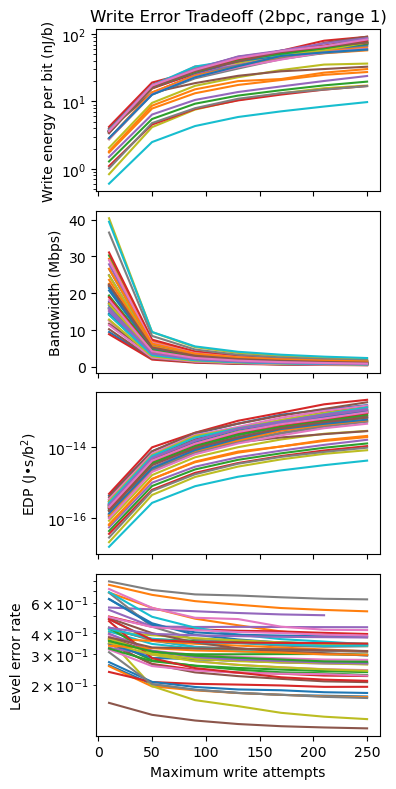

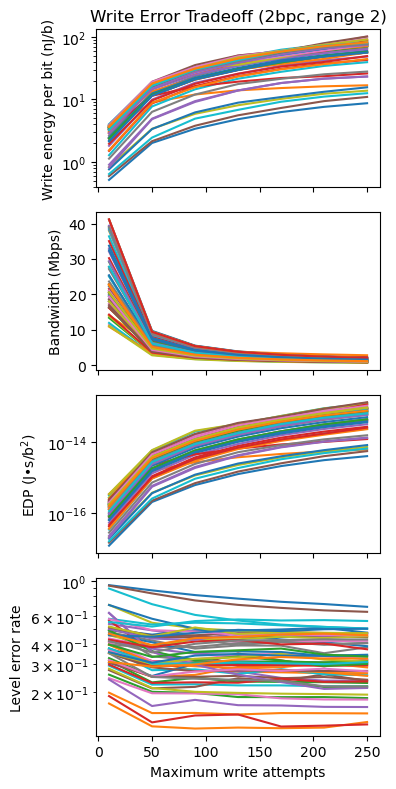

In [5]:
# Plot write BER tradeoff vs. attempts
for (bpc, lvl), d2 in edata.groupby(["bpc", "lvl"]):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    for expt, d in d2.sort_values("att").groupby("expt"):
        axs[0].set_title(f"Write Error Tradeoff ({bpc}bpc, range {lvl})")
        axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
        axs[0].set_yscale("log")
        axs[0].set_ylabel("Write energy per bit (nJ/b)")
        axs[1].plot(d["att"], d["bw"]/1e6)
        # axs[1].set_yscale("log")
        axs[1].set_ylabel("Bandwidth (Mbps)")
        axs[2].plot(d["att"], d["edp"])
        axs[2].set_yscale("log")
        axs[2].set_ylabel("EDP (J•s/b$^2$)")
        axs[3].plot(d["att"], d["cer"])
        axs[3].set_yscale("log")
        axs[3].set_ylabel("Level error rate")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_lvl{lvl}_opt_write_tradeoff.pdf")
    plt.show()